In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50V2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

In [2]:
# Directorios de los datasets
train_dir = "./datos/train"
val_dir = "./datos/val"
test_dir = "./datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    #rescale=1.0/255,
    preprocessing_function=preprocess_input,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.1,  # Desplazamiento horizontal del 10%
    height_shift_range=0.1,  # Desplazamiento vertical del 10%
    shear_range=0.1,  # Transformación de cizallamiento del 10%
    zoom_range=0.1,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.1, 1.0]  # Ajuste de brillo entre 0.1 y 1.0
)
 #evitamos el sobreajuste
#datagen_val_test = ImageDataGenerator(rescale=1.0/255)
datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


## EfficientNetB0

In [5]:
y_true_test = test_generator.classes
y_true_onehot = label_binarize(y_true_test, classes=range(num_classes))
class_names = list(val_generator.class_indices.keys())

def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.layers[-17].output 
    x = Conv2D(filters=192, kernel_size=1, strides=1, padding='valid',
            activation='selu', kernel_initializer='lecun_normal')(x) 
    x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  
    x = AlphaDropout(0.2)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

def evaluate_model(weights_path, description):
    model = build_efficientnet_model()
    model.load_weights(weights_path)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    y_pred_prob = model.predict(test_generator)
    y_pred_test = np.argmax(y_pred_prob, axis=1)

    print(f"\nTest Classification Report ({description}):")
    print(classification_report(y_true_test, y_pred_test, target_names=class_names))

    auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC (macro, one-vs-rest): {auc:.4f}")

# Evaluar los tres modelos EfficientNet con diferentes pesos
evaluate_model("./Base_Articulo/efficientnetb0_best_weights.h5", "Base Data Augmentation")
evaluate_model("./Base_DataArgumentation/efficientnetb0_best_weights.h5", "Data Augmentation Agressive")
evaluate_model("./Base_Dropout/efficientnetb0_best_weights.h5", "AlphaDropout")


100/100 [==============================] - 5s 45ms/step

Test Classification Report (Base Data Augmentation):
                      precision    recall  f1-score   support

            0_normal       0.94      1.00      0.97       200
1_ulcerative_colitis       0.92      0.93      0.92       200
            2_polyps       0.92      0.86      0.89       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.95       800
           macro avg       0.95      0.95      0.95       800
        weighted avg       0.95      0.95      0.95       800

AUC (macro, one-vs-rest): 0.9945
100/100 [==============================] - 5s 44ms/step

Test Classification Report (Data Augmentation Agressive):
                      precision    recall  f1-score   support

            0_normal       0.92      1.00      0.96       200
1_ulcerative_colitis       0.94      0.96      0.95       200
            2_polyps       0.97      0.85      0.90     

## MobileNetV2

In [7]:
y_true_test = test_generator.classes
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true_test, classes=range(n_classes))
class_names = list(test_generator.class_indices.keys())

# === Modelo base ===
model = keras.models.load_model("./Base_Articulo/mobilenetv2_gastro_model.h5")
y_pred_prob = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_prob, axis=1)

print("\nTest Classification Report with Data Augmentation:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, one-vs-rest): {auc:.4f}")

# === Modelo con Data Augmentation Agressive ===
model = keras.models.load_model("./Base_DataArgumentation/mobilenetv2_gastro_model.h5")
y_pred_prob = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_prob, axis=1)

print("\nTest Classification Report Data Augmentation Agressive:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, one-vs-rest): {auc:.4f}")

# === Modelo con AlphaDropout ===
model = keras.models.load_model("./Base_Dropout/mobilenetv2_gastro_model.h5")
y_pred_prob = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_prob, axis=1)

print("\nTest Classification Report AlphaDropout:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, one-vs-rest): {auc:.4f}")

100/100 [==============================] - 5s 43ms/step

Test Classification Report with Data Augmentation:
                      precision    recall  f1-score   support

            0_normal       1.00      0.98      0.99       200
1_ulcerative_colitis       0.95      0.97      0.96       200
            2_polyps       0.98      0.96      0.97       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.98       800
           macro avg       0.98      0.98      0.98       800
        weighted avg       0.98      0.98      0.98       800

AUC (macro, one-vs-rest): 0.9995
100/100 [==============================] - 5s 44ms/step

Test Classification Report Data Augmentation Agressive:
                      precision    recall  f1-score   support

            0_normal       1.00      0.97      0.98       200
1_ulcerative_colitis       0.95      0.97      0.96       200
            2_polyps       0.97      0.97      0.97       20

## ResNetV2

In [8]:
y_true_test = test_generator.classes
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true_test, classes=range(n_classes))
class_names = list(test_generator.class_indices.keys())

# === Modelo base ===
model = keras.models.load_model("./Base_Articulo/resnet50v2_gastro_model.h5")
y_pred_prob = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_prob, axis=1)

print("\nTest Classification Report with Data Augmentation:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, one-vs-rest): {auc:.4f}")

# === Modelo con Data Augmentation Agressive ===
model = keras.models.load_model("./Base_DataArgumentation/resnet50v2_gastro_model.h5")
y_pred_prob = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_prob, axis=1)

print("\nTest Classification Report Data Augmentation Agressive:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, one-vs-rest): {auc:.4f}")

# === Modelo con AlphaDropout ===
model = keras.models.load_model("./Base_Dropout/resnet50v2_gastro_model.h5")
y_pred_prob = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_prob, axis=1)

print("\nTest Classification Report AlphaDropout:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, one-vs-rest): {auc:.4f}")

100/100 [==============================] - 5s 47ms/step

Test Classification Report with Data Augmentation:
                      precision    recall  f1-score   support

            0_normal       1.00      0.99      0.99       200
1_ulcerative_colitis       0.89      0.86      0.88       200
            2_polyps       0.87      0.88      0.87       200
       3_esophagitis       0.97      1.00      0.98       200

            accuracy                           0.93       800
           macro avg       0.93      0.93      0.93       800
        weighted avg       0.93      0.93      0.93       800

AUC (macro, one-vs-rest): 0.9910
100/100 [==============================] - 5s 46ms/step

Test Classification Report Data Augmentation Agressive:
                      precision    recall  f1-score   support

            0_normal       1.00      0.97      0.98       200
1_ulcerative_colitis       0.87      0.86      0.87       200
            2_polyps       0.87      0.87      0.87       20

# Votación

In [4]:
# --- Configuración general ---
input_shape = (224, 224, 3)
num_classes = len(test_generator.class_indices)
class_names = list(test_generator.class_indices.keys())

# AUC de cada modelo para desempates
auc_scores = {
    "efficientnet": 0.9963,
    "mobilenet": 0.9995,
    "resnet": 0.9910
}

# === Construir modelo EfficientNetB0 ===
def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = base_model.layers[-17].output
    x = Conv2D(filters=192, kernel_size=1, strides=1, padding='valid',
               activation='selu', kernel_initializer='lecun_normal')(x)
    x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# === Cargar modelos ===
efficientnet = build_efficientnet_model()
efficientnet.load_weights("./Base_DataArgumentation/efficientnetb0_best_weights.h5")
mobilenet = load_model("./Base_Articulo/mobilenetv2_gastro_model.h5")
resnet = load_model("./Base_Articulo/resnet50v2_gastro_model.h5")

# === Inicializar arrays de resultados ===
y_true = []
y_pred = []
y_scores = []

# === Evaluación en todo el conjunto de test ===
for i in tqdm(range(len(test_generator.filenames)), desc="Evaluando por votación"):
    filepath = test_generator.filepaths[i]
    true_label = test_generator.classes[i]

    # Cargar imagen original
    img = image.load_img(filepath, target_size=input_shape[:2])
    img_array = image.img_to_array(img)

    # Preprocesar por modelo
    img_eff = preprocess_input(np.expand_dims(np.copy(img_array), axis=0))
    img_res_mob = np.expand_dims(np.copy(img_array) / 255.0, axis=0)

    # Obtener predicciones
    probs_eff = efficientnet.predict(img_eff, verbose=0)[0]
    probs_mob = mobilenet.predict(img_res_mob, verbose=0)[0]
    probs_res = resnet.predict(img_res_mob, verbose=0)[0]

    pred_eff = np.argmax(probs_eff)
    pred_mob = np.argmax(probs_mob)
    pred_res = np.argmax(probs_res)

    predictions = {
        "efficientnet": pred_eff,
        "mobilenet": pred_mob,
        "resnet": pred_res
    }

    # === Votación con desempate por AUC ===
    votes = Counter(predictions.values())
    most_common = votes.most_common()

    if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
        final_pred = most_common[0][0]
    else:
        # Empate: elegir predicción del modelo con mejor AUC
        best_model = max(auc_scores, key=auc_scores.get)
        final_pred = predictions[best_model]

    # === Guardar resultados ===
    y_true.append(true_label)
    y_pred.append(final_pred)

    # Para AUC: usar promedio de probabilidades normalizadas
    avg_probs = (probs_eff + probs_mob + probs_res) / 3
    y_scores.append(avg_probs)

# === Cálculo de métricas ===
acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
try:
    auc = roc_auc_score(y_true, y_scores, multi_class='ovr')
except:
    auc = "No calculable (verifica si hay muestras de todas las clases)"

print("\n--- Resultados del modelo por votación ---")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc}")

Evaluando por votación: 100%|██████████| 800/800 [02:47<00:00,  4.77it/s]


--- Resultados del modelo por votación ---
Accuracy: 0.9800
Recall: 0.9800
F1-score: 0.9800
AUC: 0.9988166666666666


In [7]:
# === Binarizar etiquetas para ROC multiclase ===
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# === Inicializar diccionario para curvas ROC ===
roc_curves = {}

# Modelo por votación (ya tienes los y_scores promedio)
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(y_scores).ravel())
roc_auc = auc(fpr, tpr)
roc_curves["Votación"] = (fpr, tpr, roc_auc)

# EfficientNet
eff_scores = []
for i in range(len(test_generator.filenames)):
    filepath = test_generator.filepaths[i]
    img = image.load_img(filepath, target_size=input_shape[:2])
    img_array = image.img_to_array(img)
    img_eff = preprocess_input(np.expand_dims(np.copy(img_array), axis=0))
    eff_scores.append(efficientnet.predict(img_eff, verbose=0)[0])
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(eff_scores).ravel())
roc_auc = auc(fpr, tpr)
roc_curves["EfficientNet"] = (fpr, tpr, roc_auc)

# MobileNet
mob_scores = []
for i in range(len(test_generator.filenames)):
    filepath = test_generator.filepaths[i]
    img = image.load_img(filepath, target_size=input_shape[:2])
    img_array = image.img_to_array(img)
    img_mob = np.expand_dims(np.copy(img_array) / 255.0, axis=0)
    mob_scores.append(mobilenet.predict(img_mob, verbose=0)[0])
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(mob_scores).ravel())
roc_auc = auc(fpr, tpr)
roc_curves["MobileNet"] = (fpr, tpr, roc_auc)

# ResNet
res_scores = []
for i in range(len(test_generator.filenames)):
    filepath = test_generator.filepaths[i]
    img = image.load_img(filepath, target_size=input_shape[:2])
    img_array = image.img_to_array(img)
    img_res = np.expand_dims(np.copy(img_array) / 255.0, axis=0)
    res_scores.append(resnet.predict(img_res, verbose=0)[0])
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(res_scores).ravel())
roc_auc = auc(fpr, tpr)
roc_curves["ResNet"] = (fpr, tpr, roc_auc)

# === Graficar todas las curvas ROC ===
plt.figure(figsize=(10, 7))
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Comparativa de Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


TypeError: 'numpy.float64' object is not callable

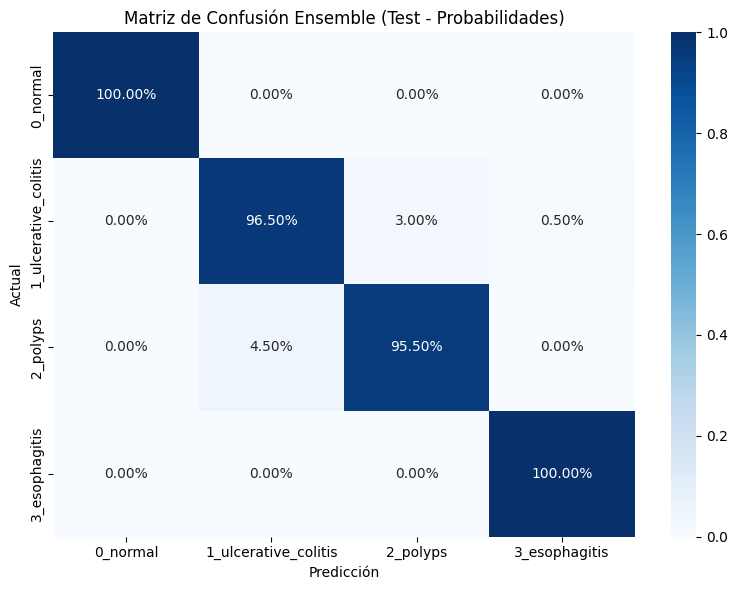

In [6]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calcular matriz de confusión
cm_ensemble = confusion_matrix(y_true, y_pred)
cm_ensemble_prob = confusion_matrix_prob(cm_ensemble)

# Mostrar la matriz de confusión del ensemble (Test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble_prob, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión Ensemble (Test - Probabilidades)')
plt.tight_layout()
plt.show()
